# Approaach -1 

In this, by barely doung basic preprocessing of the target column we are making two components from all the feature's. 

Steps: 
- We'll be importing the required paackages. 
- Converting the features into appropriate data types. 
- Binning the target column into categories. 
- Plotting the scatter plot in the 2-D SPACE.
- Gradient descent in the t-SNE & visualization. 

In [1]:
## Importing packages

import numpy as np
import pandas as pd
import time
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

from sklearn.utils.extmath import*
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
## Reading the data 

df=pd.read_csv("forestfires.csv")

In [3]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
## Basic preprocessing steps like converting categories into appropriate types 

object_columns=df.select_dtypes(['object']).columns
df[object_columns]=df[object_columns].apply(lambda x: x.astype('category'))

cat_columns=df.select_dtypes(['category']).columns
df[cat_columns]=df[cat_columns].apply(lambda x: x.cat.codes)

In [5]:
## Binning the data into bins

df['area_log']= np.log(df.area +1)
df['area_bins'] = pd.qcut(df['area_log'],2, labels=[0,1])
df.drop(['area','area_log'],axis=1,inplace=True)

In [6]:
y=df.pop('area_bins')
X=df

In [7]:
## Applying t-SNE algorithm with 2 components and 1000 iteration's

df_proj = TSNE(random_state=RS, perplexity=50).fit_transform(X)

In [8]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls",2))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-3.868685, -1.4726782, '0'), Text(-3.8736129, -2.2917633, '1')])

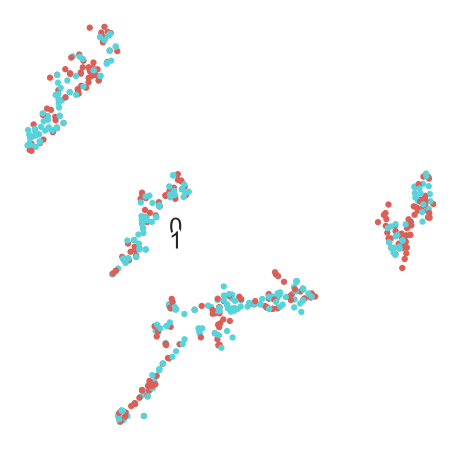

In [ ]:
#plotting the scatter plot of the t-SNE 2d visualization 
scatter(df_proj, y)

In [ ]:
#  This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, n_iter_check=1,n_iter_without_progress=30,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,kwargs=None,
                      args=[]):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i
sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [ ]:
X_proj = TSNE(random_state=RS).fit_transform(X)

X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(2), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("./Approaaach-1.gif", fps=30)
animation.w

MoviePy - Building file ./Approaaach-1.gif with imageio.


t:  84%|████████████████████████████████████████████████████████▎          | 558/664 [01:08<00:21,  4.96it/s, now=None]

## Observations: 

- Both the components are overlapped in the 2-d space, we can visualize them clearly in the 3-d space. 